In [1]:
from langchain_qdrant import Qdrant
from langchain.embeddings import OpenAIEmbeddings
from langchain.storage import InMemoryByteStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import models

api_key = ""

qdrant_client = QdrantClient(
    api_key="woXKPNeAD8uq1fVpLLPrDMX5AM4xyjAnLDPzszQuzZKFn",
    https=False,
)

try:
    qdrant_client.get_collection(collection_name="summaries-tgs")
except Exception as e:
    qdrant_client.create_collection(collection_name="summaries-tgs",vectors_config=models.VectorParams(
                size=1536, distance=models.Distance.COSINE
            ))
    
embedding_function=OpenAIEmbeddings(api_key =api_key )

vectorstore = Qdrant(client=qdrant_client ,collection_name="summaries-tgs",embeddings=embedding_function)

# The storage layer for the parent documents
store = InMemoryByteStore()

id_key = "doc_id"

# The retriever (empty to start)
# retriever = MultiVectorRetriever(
#     vectorstore=vectorstore,
#     byte_store=store,
#     id_key=id_key,
# )

# retriever = vectorstore.as_retriever(
#     search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5}
# )
retriever = vectorstore.as_retriever(
            search_type="mmr",
            search_kwargs={"k": 5, "lambda_mult": 0.25, "fetch_k": 50},
        )


/Users/felipeescobar/Documents/llm_fastapi/venv/lib/python3.10/site-packages/qdrant_client/qdrant_remote.py:130: UserWarning: Api key is used with an insecure connection.
  warnings.warn("Api key is used with an insecure connection.")
/Users/felipeescobar/Documents/llm_fastapi/venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [13]:
from typing import Annotated, Literal, Sequence, TypedDict, Union

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.agents import AgentAction, AgentFinish

from langchain.tools.retriever import create_retriever_tool
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

retriever_tool = create_retriever_tool(
    retriever,
    "therapeutic_guidelines_smoking",
    "The Ministry of Health, through the Secretariat of Specialized Health Care and the Secretariat of Science, Technology, Innovation, and Strategic Inputs in Health, has approved the Clinical Protocol and Therapeutic Guidelines for Smoking. This ordinance updates the national parameters for diagnosing, treating, and following up on smoking-related health issues in Brazil. The protocol, available on the Ministry of Health’s website, includes diagnostic criteria, treatment options, and guidelines for health professionals. It mandates the informed consent of patients regarding potential risks and side effects and requires SUS managers to structure and coordinate the healthcare network for effective treatment of smoking",
)

tools = [retriever_tool]

### Edges


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]
    chat_history: list[BaseMessage]


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True, api_key = api_key)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")


    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo", api_key = api_key)
    model = model.bind_tools(tools)
#     prompt = PromptTemplate(
#         template="""
# You are an expert and helpful in the field of healthcare and medical and you have tools to get info about this. If a question does not match your field say: Eu não tenho conhecimento sobre esse assunto, sei apenas responder perguntas sobre saúde.
# Question: {messages}
#         """,
#         input_variables=["messages"],
#     )
    

#     # Chain
#     chain = prompt | model
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question in portuguese: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True, api_key = api_key)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True,api_key = api_key)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


In [14]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.set_entry_point("agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

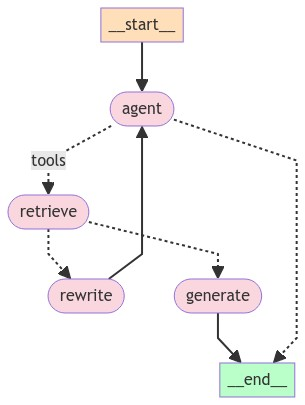

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [17]:
import pprint

inputs = {
    "messages": [
        ("user", "Quais os códigos do cids para tabagismo?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_PLDGKDX9G3OGM2ohMlOwOvgW', 'function': {'arguments': '{"query":"CID codes for smoking"}', 'name': 'therapeutic_guidelines_smoking'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-e3d7a3c0-ca6b-45b1-824b-91350b193b92-0', tool_calls=[{'name': 'therapeutic_guidelines_smoking', 'args': {'query': 'CID codes for smoking'}, 'id': 'call_PLDGKDX9G3OGM2ohMlOwOvgW'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='The document is a list of various studies and reviews on smoking cessation interventions for different populations, including young people, pregnant women, adults aged 50 or older, the elderly, individuals with tuberculosis, oncology patients, head and neck cancer patients, individuals in treatment for substan